#Importação das Bibliotecas
Carrega bibliotecas que são ferramentas de trabalho para:

- Manipular dados (pandas, numpy)

- Fazer gráficos (matplotlib, seaborn)

- Construir modelos de machine learning (sklearn)

Bibliotecas específicas serão importandas ao longo do script

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import pandas as pd
import os
import shap

# Coleta de Dados
Vamos fazer o download da base de dados e armazená-la em um DataFrame.

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adilshamim8/student-depression-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'student-depression-dataset' dataset.
Path to dataset files: /kaggle/input/student-depression-dataset


In [ ]:
# Lista todos os arquivos e diretórios baixados
dataset_name = os.listdir(path)[0]
print(os.listdir(path))

['student_depression_dataset.csv']


##Criar o DataFrame

In [ ]:
# Criação do dataframe
df_dataset = pd.read_csv(os.path.join(path, dataset_name))

#Análise Exploratória dos Dados - 1a Parte
Esta primeira análise exploratória tem por objetivo conhecer os dados brutos e verificar a necessidade de transformações.

##Tipo dos Dados

In [ ]:
print(df_dataset.dtypes)

id                                         int64
Gender                                    object
Age                                      float64
City                                      object
Profession                                object
Academic Pressure                        float64
Work Pressure                            float64
CGPA                                     float64
Study Satisfaction                       float64
Job Satisfaction                         float64
Sleep Duration                            object
Dietary Habits                            object
Degree                                    object
Have you ever had suicidal thoughts ?     object
Work/Study Hours                         float64
Financial Stress                          object
Family History of Mental Illness          object
Depression                                 int64
dtype: object


## Estatística	Descritiva
A análise descritiva é a primeira etapa da análise de dados, e tem como objetivo resumir, organizar e entender as principais características de um conjunto de dados de forma simples e objetiva, sem tirar conclusões causais ou fazer previsões.

* count:	Número de valores não nulos (não NaN)
* mean:	Média aritmética dos valores
* std:	Desvio padrão (medida de dispersão)
* min:	Valor mínimo
* 25%:	Primeiro quartil (Q1) – 25% dos dados estão abaixo desse valor
* 50%:	Mediana (Q2) – metade dos dados estão abaixo desse valor
* 75%:	Terceiro quartil (Q3) – 75% dos dados estão abaixo desse valor
* max:	Valor máximo

In [ ]:
df_dataset.describe()

,id,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Depression
count,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000
mean,70442.149421,25.822300,3.141214,0.000430,7.656104,2.943837,0.000681,7.156984,0.585499
std,40641.175216,4.905687,1.381465,0.043992,1.470707,1.361148,0.044394,3.707642,0.492645
min,2.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35039.000000,21.000000,2.000000,0.000000,6.290000,2.000000,0.000000,4.000000,0.000000
50%,70684.000000,25.000000,3.000000,0.000000,7.770000,3.000000,0.000000,8.000000,1.000000
75%,105818.000000,30.000000,4.000000,0.000000,8.920000,4.000000,0.000000,10.000000,1.000000
max,140699.000000,59.000000,5.000000,5.000000,10.000000,5.000000,4.000000,12.000000,1.000000


In [ ]:
dep = df_dataset['Depression'].value_counts().reset_index()
dep.columns = ['Depressao', 'Quantidade']
print(dep)

   Depressao  Quantidade
0          1       16336
1          0       11565


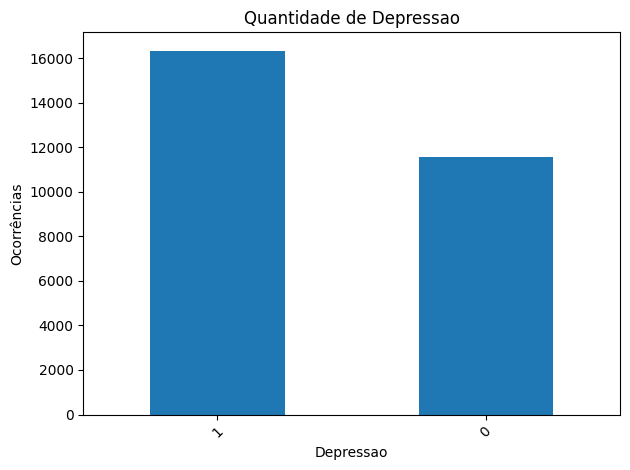

In [ ]:
df_dataset['Depression'].value_counts().plot(kind='bar')
plt.title('Quantidade de Depressao')
plt.xlabel('Depressao')
plt.ylabel('Ocorrências')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##Total Com Depressão x Sem Depressão

In [ ]:
# Total de registros no DataFrame
total_registros = len(df_dataset)

# Soma diagnostico de depressao
total_nao_dep = dep[dep['Depressao'] == 0]['Quantidade'].sum()

# Soma apenas as dep (exclui no depressao(0))
total_dep = dep[dep['Depressao'] != 0]['Quantidade'].sum()

# Calcula a porcentagem
percentual_nao_dep = (total_nao_dep / total_registros) * 100
percentual_dep = (total_dep / total_registros) * 100

# Exibe o resultado
print(f"Total de registros.: {total_registros}")
print(f"Total de sem depressao: {total_nao_dep} ou {percentual_nao_dep:.2f}% do total")
print(f"Total de depressao....: {total_dep} ou {percentual_dep:.2f}% do total")


Total de registros.: 27901
Total de sem depressao: 11565 ou 41.45% do total
Total de depressao....: 16336 ou 58.55% do total


#Engenharia de Dados

##Eliminar Valores Nulos
A eliminação de valores nulos deverá ser feita com cuidados. É necessário avaliar a real necessidade de eliminá-los, pois há alternativas, por exemplo, substituir os valores faltantes pela moda ou pela média.

In [ ]:
df_dataset.isnull().sum()

,0
id,0
Gender,0
Age,0
City,0
Profession,0
Academic Pressure,0
Work Pressure,0
CGPA,0
Study Satisfaction,0
Job Satisfaction,0


Não há dados nulos

##Eliminar as Linhas Duplicadas
Já sabemos que não há duplicação, então, este passo não seria necessário, mas fica a título de exemplo

#Cabeçalho com coluna 'Sleep Duration' formatada

Tirar o 'hours' e substituir 'Less than' por '<' e 'More than' por '>'.

In [ ]:
formated_sleep_duration = df_dataset['Sleep Duration'].str.replace("'", "").str.strip('hours').str.replace(r'^Less than', '<', regex=True).str.replace(r'^More than', '>', regex=True)
df_dataset['Sleep Duration'] = formated_sleep_duration

df_dataset.head()

,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,5-6,Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,5-6,Moderate,BSc,No,3.0,2.0,Yes,0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,< 5,Healthy,BA,No,9.0,1.0,Yes,0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,7-8,Moderate,BCA,Yes,4.0,5.0,Yes,1
4,32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,5-6,Moderate,M.Tech,Yes,1.0,1.0,No,0


#Rodapé com coluna 'Sleep Duration' formatada

Tirar o 'hours' e substituir 'Less than' por '<' e 'More than' por '>'.

In [ ]:
formated_sleep_duration = df_dataset['Sleep Duration'].str.replace("'", "").str.strip('hours').str.replace(r'^Less than', '<', regex=True).str.replace(r'^More than', '>', regex=True)
df_dataset['Sleep Duration'] = formated_sleep_duration

df_dataset.tail()

,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
27896,140685,Female,27.0,Surat,Student,5.0,0.0,5.75,5.0,0.0,5-6,Unhealthy,'Class 12',Yes,7.0,1.0,Yes,0
27897,140686,Male,27.0,Ludhiana,Student,2.0,0.0,9.40,3.0,0.0,< 5,Healthy,MSc,No,0.0,3.0,Yes,0
27898,140689,Male,31.0,Faridabad,Student,3.0,0.0,6.61,4.0,0.0,5-6,Unhealthy,MD,No,12.0,2.0,No,0
27899,140690,Female,18.0,Ludhiana,Student,5.0,0.0,6.88,2.0,0.0,< 5,Healthy,'Class 12',Yes,10.0,5.0,No,1
27900,140699,Male,27.0,Patna,Student,4.0,0.0,9.24,1.0,0.0,< 5,Healthy,BCA,Yes,2.0,3.0,Yes,1


In [ ]:
# Quantidade total antes
total_antes = len(df_dataset)

# Quantidade de duplicadas
duplicadas = df_dataset.duplicated().sum()

# Remover duplicadas
df_dataset = df_dataset.drop_duplicates()

# Quantidade total depois
total_depois = len(df_dataset)

print(f"Total de linhas antes......................: {total_antes}")
print(f"Linhas duplicadas detectadas...............: {duplicadas}")
print(f"Total de linhas depois do drop_duplicates(): {total_depois}")

Total de linhas antes......................: 27901
Linhas duplicadas detectadas...............: 0
Total de linhas depois do drop_duplicates(): 27901


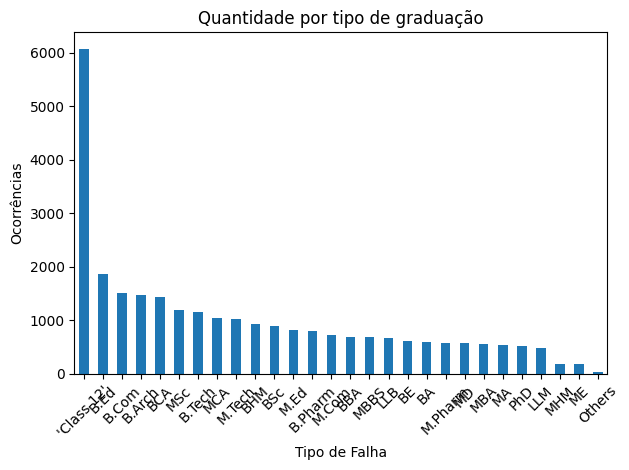

In [ ]:
#Exibe um gráfico da quantidade de falhas por 'Failure Code'
df_dataset['Degree'].value_counts().plot(kind='bar')
plt.title('Quantidade por tipo de graduação')
plt.xlabel('Tipo de Falha')
plt.ylabel('Ocorrências')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Análise Exploratória dos Dados - 2a Parte
Não há necessidade de repetir os comando da 1a Parte, pois não houve mudança dos dados (nenhum valor nulo, por exemplo). Então, vamos aproveitar para fazer mais análises e gráficos

##Histogramas das Variáveis Numéricas

* O **histograma** (barras) mostra a **frequência** de registros em faixas específicas de temperatura do ar.
* A **linha azul** representa a **curva de densidade estimada** — ela suaviza os dados e mostra como os valores estão concentrados.
* O eixo **X** mostra a temperatura do ar em Kelvin.
* O eixo **Y** mostra quantas amostras estão em cada faixa de temperatura.

### *Interpretação:*

Vamos fazer para o primeiro. Convido você a fazer para os demais.

| Observação                                                      | Significado                                                                       |
| --------------------------------------------------------------- | --------------------------------------------------------------------------------- |
| A maior parte dos dados está entre **297K e 303K**              | Temperaturas de operação típicas ficam nessa faixa (\~24°C a 30°C)                |
| A distribuição tem vários **picos** (multimodal)                | Pode haver grupos de máquinas ou momentos distintos de operação                   |
| Existe uma **simetria moderada**, com leve inclinação à direita | Mostra que há **alguns casos com temperaturas mais altas**, mas sem grande desvio |

### *Relação com falhas:*

Apesar de ser uma variável bem distribuída e aparentemente "estável", sabemos por análises anteriores (como boxplots e pairplots) que:

* **Falhas como Heat Dissipation Failure** tendem a ocorrer quando a temperatura do ar está **acima de 302K**.
* Isso pode ser confirmado visualmente nesse gráfico: a “cauda direita” da curva (temperaturas maiores) é menos frequente, mas **potencialmente crítica**.


### *Resultado:*

Este gráfico mostra como a temperatura do ar varia na nossa base. A maioria das medições está concentrada perto dos 300K (cerca de 27°C), o que parece ser uma condição normal. Mas há alguns casos onde a temperatura é mais alta, e foi justamente nessas faixas que algumas falhas apareceram, como problemas de dissipação de calor.

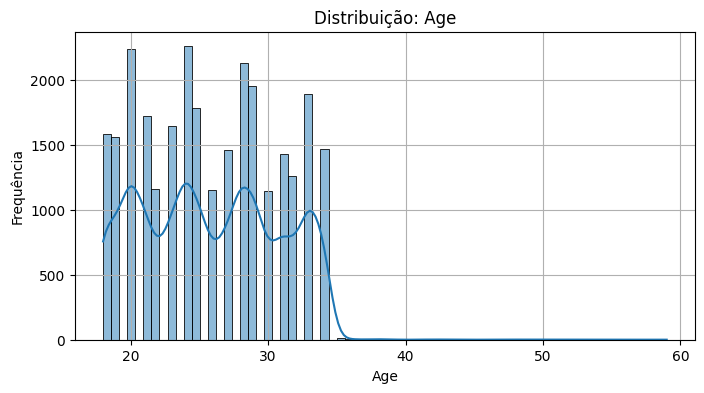

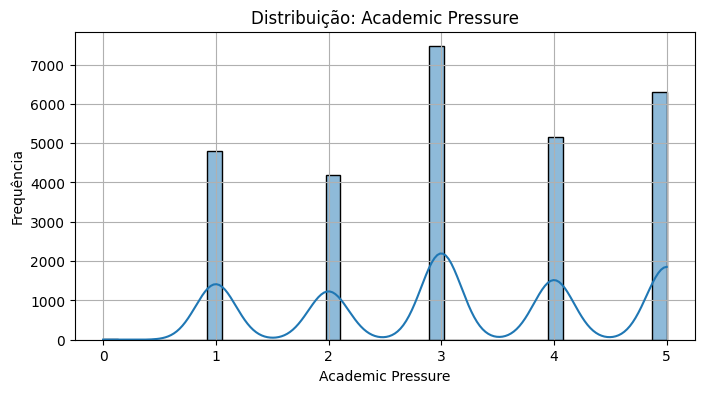

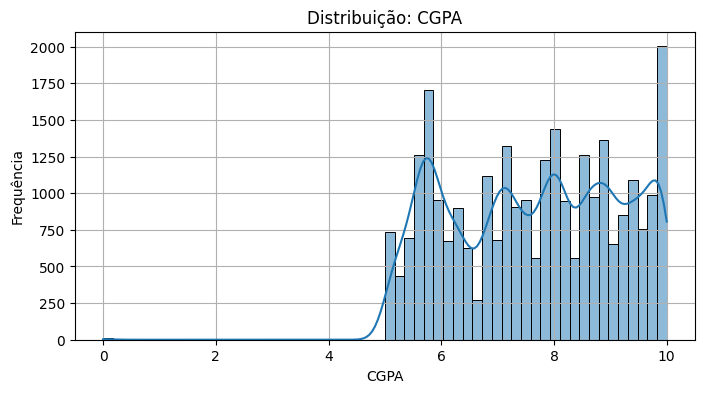

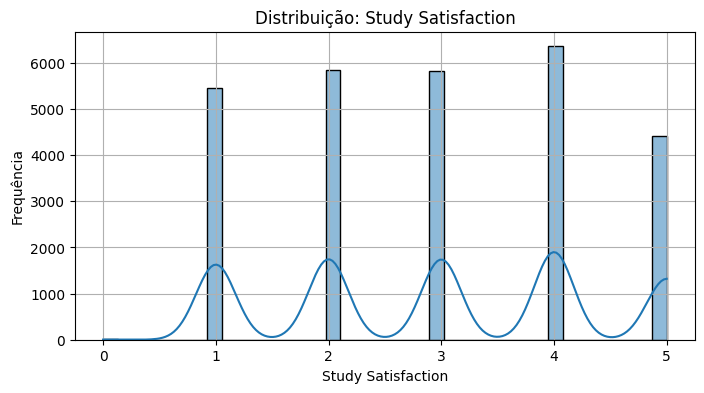

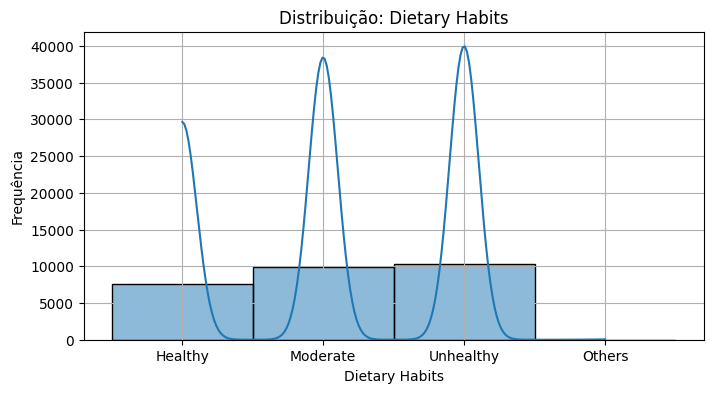

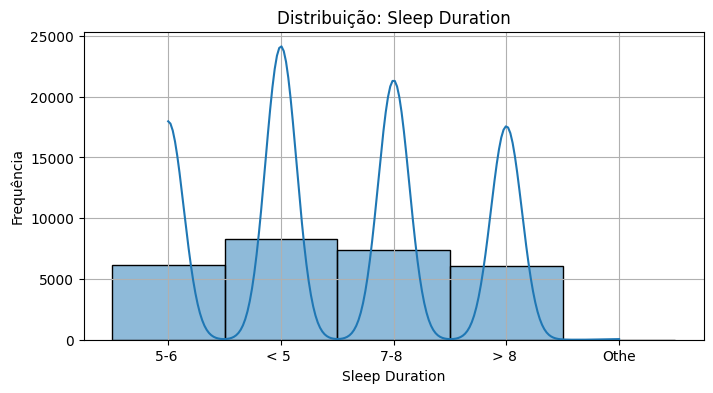

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

variaveis = ['Age', 'Academic Pressure', 'CGPA', 'Study Satisfaction', 'Dietary Habits', 'Sleep Duration']

for var in variaveis:
    plt.figure(figsize=(8, 4))
    sns.histplot(df_dataset[var], kde=True)
    plt.title(f'Distribuição: {var}')
    plt.xlabel(var)
    plt.ylabel("Frequência")
    plt.grid(True)
    plt.show()


##Pairplot

Esse gráfico compara **todas as variáveis numéricas duas a duas**, usando dispersão (scatterplots) e densidade (diagonal). Ele é segmentado por **tipo de falha (`Failure Type`)**, usando **cores diferentes para cada classe**.

Esse gráfico mostra se há agrupamentos naturais de pontos (falhas) com base em combinações de variáveis. Isso pode mostrar, por exemplo, que falhas de "Power Failure" acontecem com baixa rotação e alto torque.

### *Eixos:*

* Linhas = variável no eixo Y
* Colunas = variável no eixo X
* Diagonal = distribuição (densidade) de cada variável


### *Distribuições diagonais (autocorrelacionadas)*

* As curvas mostram a **distribuição dos valores por variável**.
* Por exemplo, a maioria dos valores de `Torque` está entre **35 e 55 Nm**, mas com **alguns pontos acima de 70** → outliers possivelmente relacionados a falhas.

### *Padrões de falha por cor (fora da diagonal)*

| Variáveis comparadas          | O que se observa?                                                                                       |
| ----------------------------- | ------------------------------------------------------------------------------------------------------- |
| **Air Temp × Process Temp**   | Correlação quase perfeita (esperado fisicamente)                                                        |
| **Torque × Rotational Speed** | Relação inversa clara (quando torque sobe, rotação tende a cair — também esperado)                      |
| **Torque × Failure Type**     | 🔥 Falhas (especialmente Power Failure e Tool Wear Failure) **concentradas em regiões com torque alto** |
| **Tool Wear × Torque/Speed**  | Algumas falhas ocorrem com **desgaste elevado e torque alto**                                           |

### *O que chama atenção?*

* **Power Failure (laranja)** aparece muito mais em regiões com **alta rotação** e **alto torque** → padrão crítico de operação extrema.
* **Tool Wear Failure (verde)** ocorre em regiões de **torque alto + desgaste alto**.
* **Heat Dissipation Failure (roxo)** aparece onde a **temperatura do ar é mais alta**.
* A classe **"No Failure" (azul)** está **muito espalhada**, cobrindo quase todo o gráfico → normal, pois é a classe dominante.

Esse gráfico mostra como as variáveis se comportam em pares e como os diferentes tipos de falha se distribuem nesses espaços. Por exemplo, falhas de desgaste ocorrem quando o torque e o desgaste estão altos. Já falhas de dissipação de calor acontecem quando a temperatura do ar é maior. Esse tipo de visualização nos ajuda a entender que tipo de combinação de condições pode levar a uma falha.


TypeError: The x variable is categorical, but one of ['numeric', 'datetime'] is required

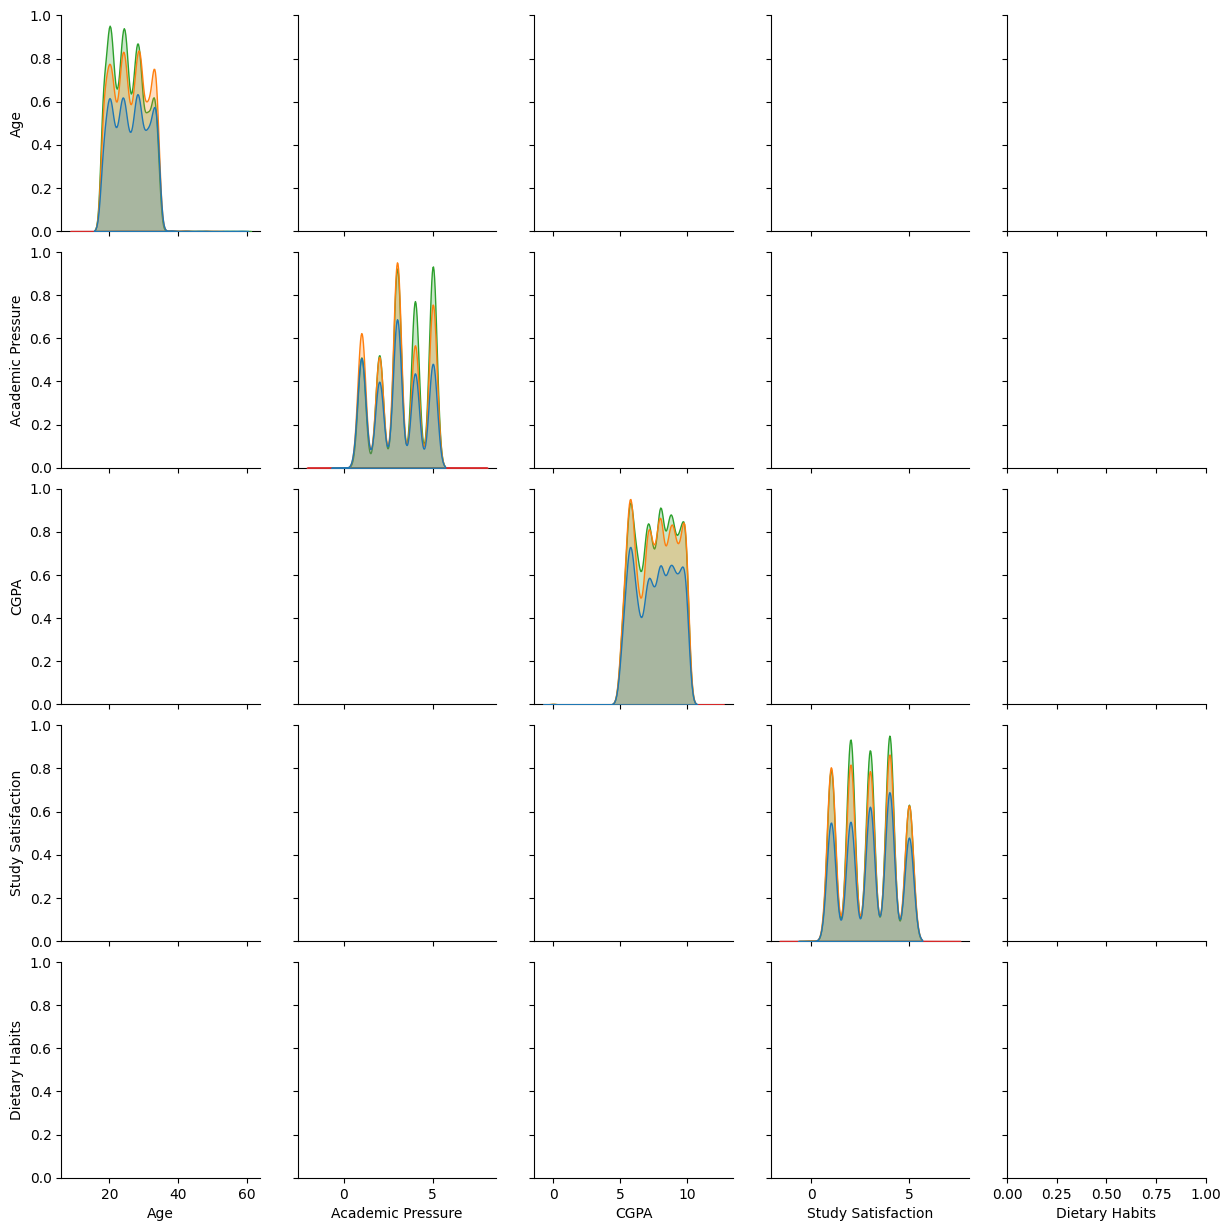

In [ ]:
sns.pairplot(df_dataset, hue="Dietary Habits", vars=variaveis)

##Boxplots

Um boxplot (gráfico de caixa) **resume a distribuição de valores** em cinco partes:

* **Linha central (mediana)**: valor do meio
* **Caixa**: intervalo entre o 1º quartil (25%) e o 3º quartil (75%)
* **“Bigodes” (linhas finas)**: mostram a faixa de valores dentro de 1,5x a amplitude interquartil (IQR)
* **Pontos fora da caixa** (se houver): são considerados **outliers**

### *O que este gráfico mostra?*

Vamos fazer a análise somente para o primeiro gráfico. Convido você a fazer para os demais.

Ele compara a temperatura do ar entre os diferentes **tipos de falha**:

| Tipo de Falha                | Observação sobre Temperatura                                            |
| ---------------------------- | ----------------------------------------------------------------------- |
| **No Failure**               | Mediana \~300K, dispersão normal                                        |
| **Power Failure**            | Similar a “No Failure”, talvez um pouco mais quente                     |
| **Tool Wear Failure**        | Também próximo de 300K, sem destaque claro                              |
| **Overstrain Failure**       | Levemente mais fria que as demais                                       |
| **Random Failures**          | Varia mais, tem uma mediana levemente mais alta                         |
| **Heat Dissipation Failure** | 📌 **Temperatura claramente mais alta** (\~302–304K) e mais concentrada |


### Interpretação prática*

* A temperatura do ar **não varia muito entre os tipos de falha** — a maioria fica em torno de **300 K (\~27 °C)**.
* A exceção é a **Heat Dissipation Failure**, que ocorre com **temperaturas consistentemente mais altas**.

  * Isso faz **sentido físico**, já que o nome indica falha no resfriamento → ar mais quente ao redor do sistema.


### *Resultado*

Este gráfico mostra que, na maioria dos tipos de falha, a temperatura do ar não muda muito. Mas no caso de falha de dissipação de calor, o ar está claramente mais quente. Isso pode indicar que o sistema está retendo calor e não está conseguindo resfriar direito — o que ajuda a entender esse tipo de falha.

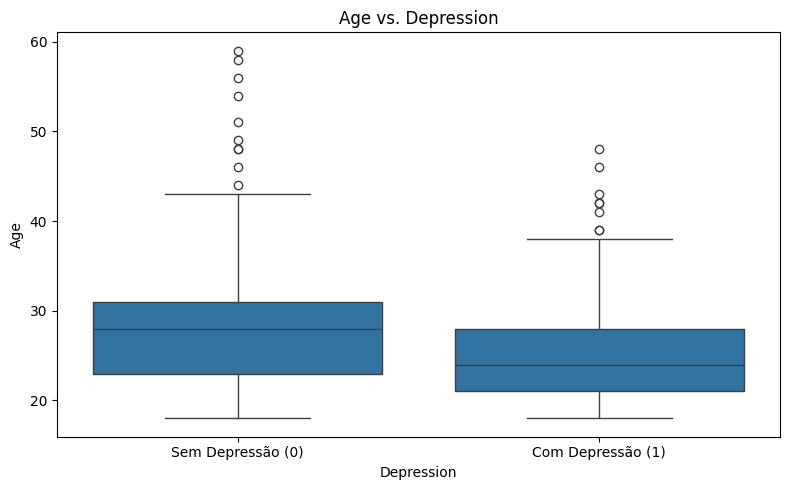

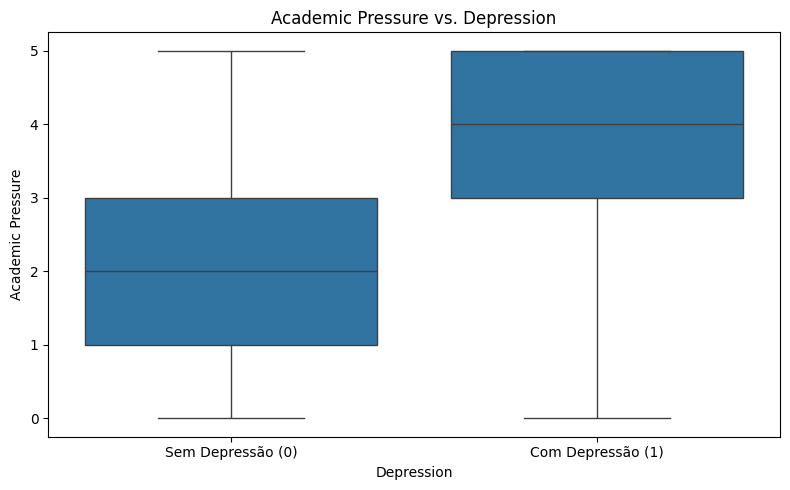

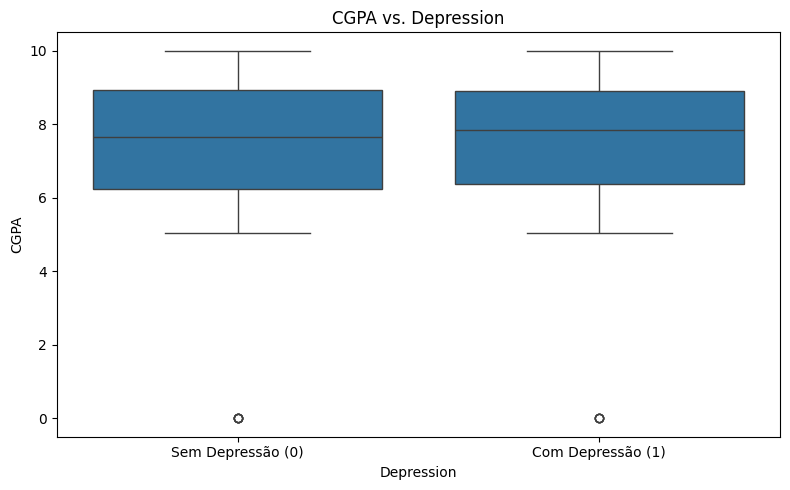

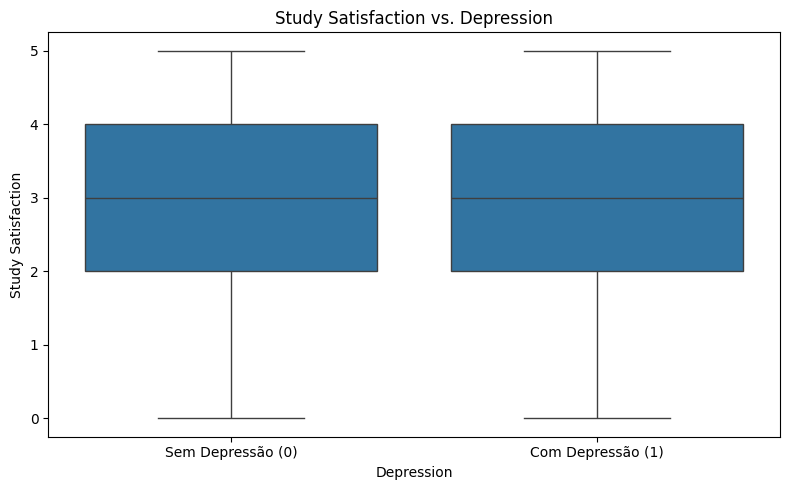

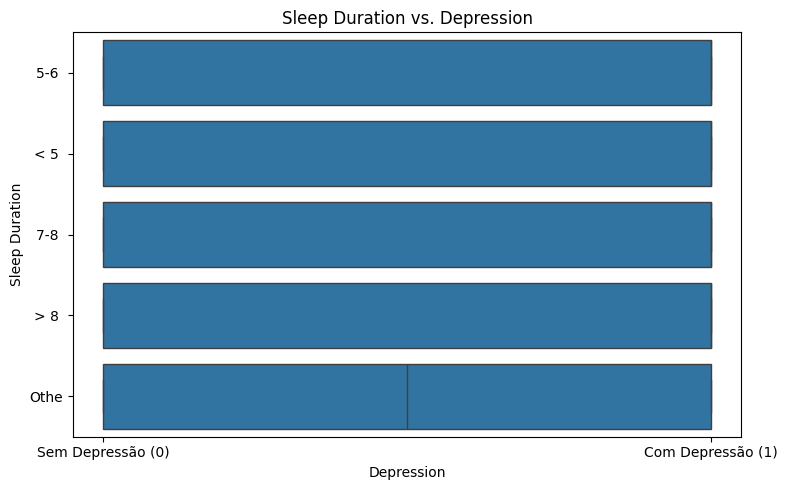

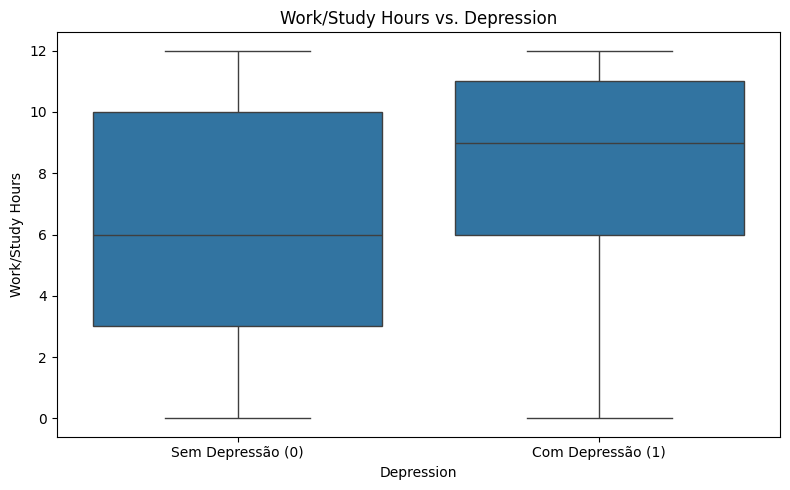

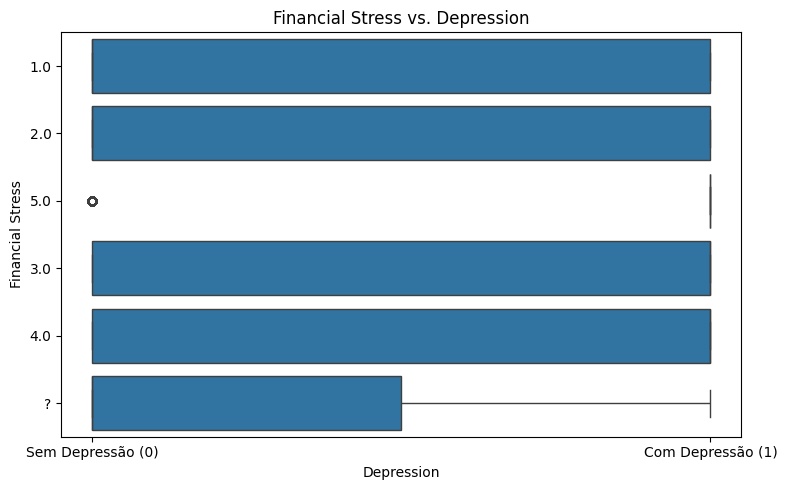

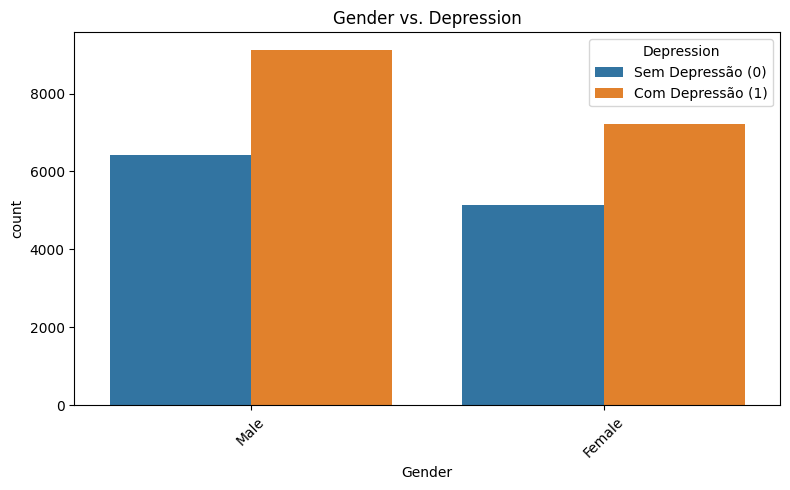

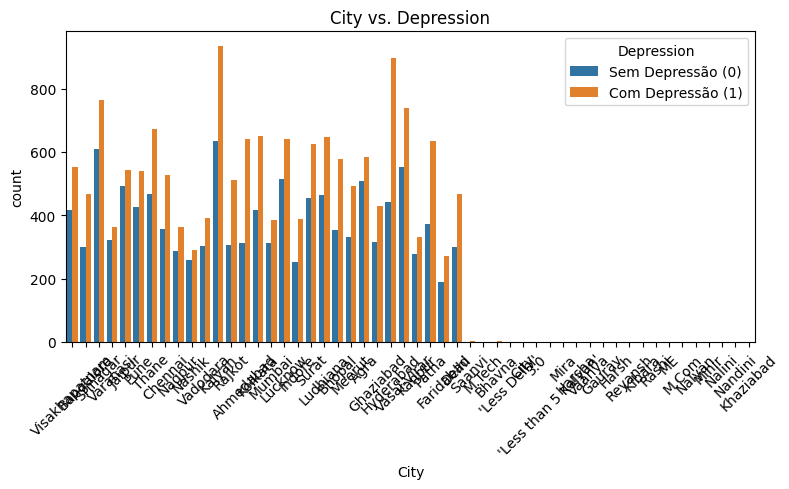

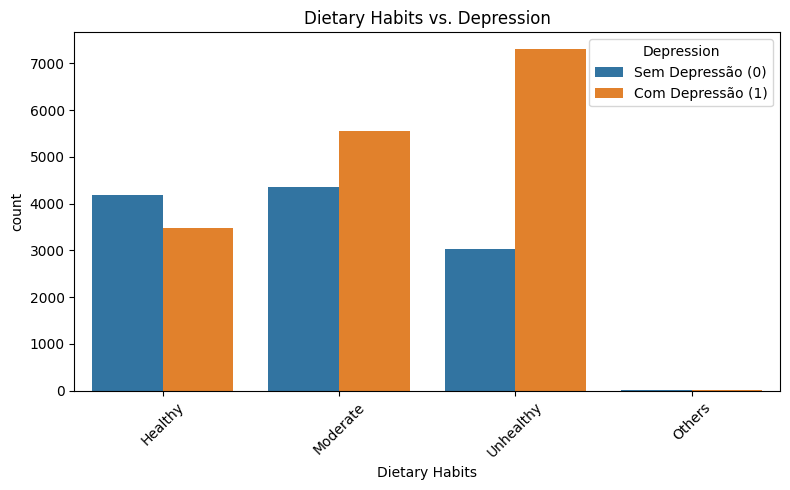

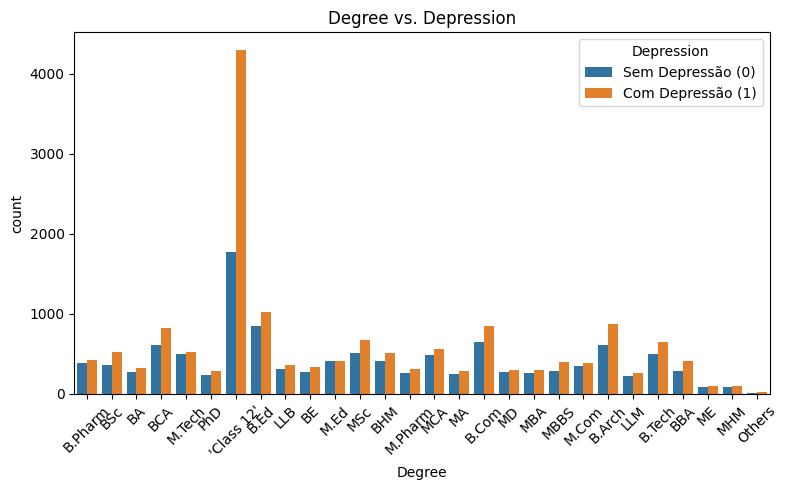

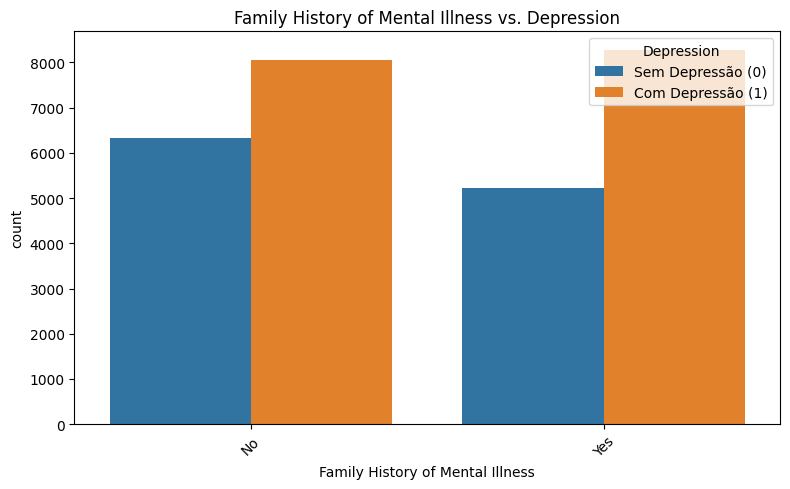

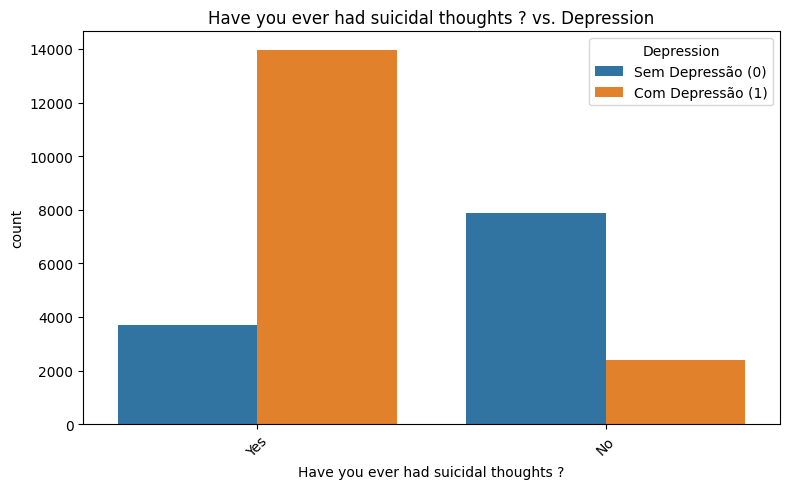

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# ===============================
# BOXPlots - variáveis numéricas
# ===============================
variaveis_numericas = [
    'Age',
    'Academic Pressure',
    'CGPA',
    'Study Satisfaction',
    'Sleep Duration',
    'Work/Study Hours',
    'Financial Stress'
]

for var in variaveis_numericas:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df_dataset, x='Depression', y=var)
    plt.title(f'{var} vs. Depression')
    plt.xticks([0, 1], ['Sem Depressão (0)', 'Com Depressão (1)'])
    plt.tight_layout()
    plt.show()


# ===============================
# COUNTPLOTS - variáveis categóricas
# ===============================
variaveis_categoricas = [
    'Gender',
    'City',
    'Dietary Habits',
    'Degree',
    'Family History of Mental Illness',
    'Have you ever had suicidal thoughts ?'
]

for var in variaveis_categoricas:
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df_dataset, x=var, hue='Depression')
    plt.title(f'{var} vs. Depression')
    plt.xticks(rotation=45)
    plt.legend(title="Depression", labels=["Sem Depressão (0)", "Com Depressão (1)"])
    plt.tight_layout()
    plt.show()



## Matriz de Correlação Completa (Mapa de Calor)

A **matriz de correlação de Pearson** mede o **grau de relação linear** entre pares de variáveis.

* Valores próximos de **1** = relação linear positiva forte
* Valores próximos de **−1** = relação linear negativa forte
* Valores próximos de **0** = pouca ou nenhuma relação linear


### *Correlações interessantes entre as variáveis*

| Par de variáveis              | Correlação | O que isso diz                                                                                                     |
| ----------------------------- | ---------- | ------------------------------------------------------------------------------------------------------------------ |
| **Air temp ↔ Process temp**   | +0.88      | Andam juntas — provavelmente aumentam ao mesmo tempo                                                               |
| **Torque ↔ Rotational speed** | −0.88      | Relação **fortemente inversa**: quanto mais torque, menor a rotação (ou vice-versa) — isso faz sentido fisicamente |
| **Outros pares**              | ≈ 0        | Pouca relação direta entre outras variáveis                                                                        |

### *Como isso se conecta à árvore de decisão?*

* **Mesmo que a correlação seja baixa**, a árvore **ainda pode usar essas variáveis** para fazer boas divisões — pois a árvore **não depende apenas de relações lineares**.
* Por exemplo:

  * **Torque e Rotational speed** têm correlação negativa forte entre si, mas **podem ser úteis em ramos distintos da árvore**.

### *Resultado*

Este mapa de calor mostra relações entre as variáveis, não com falhas. Em manutenção preditiva, ele revela co-variações e redundâncias (multicolinearidade) e inspira features derivadas. Depois, modelos não lineares (como árvores) capturam padrões e interações que a correlação linear não mostra — lembre: correlação ≠ causalidade.

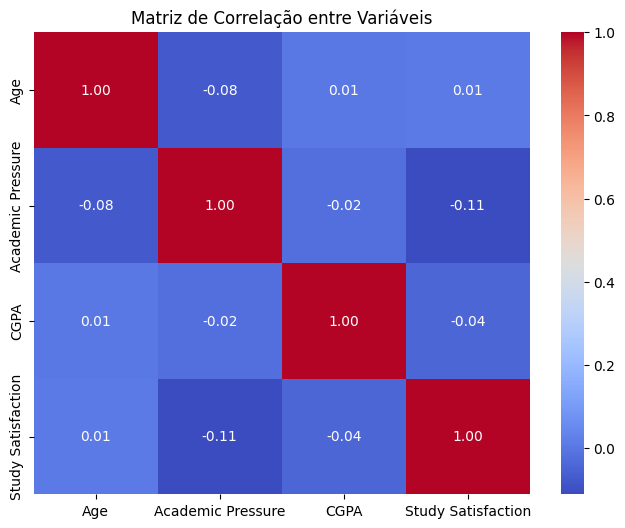

In [ ]:
corr_matrix = df_dataset[variaveis].corr(numeric_only=True)

import seaborn as sns, matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação entre Variáveis')
plt.show()

##Matriz de Correlação entre as Variáveis e o a Falha

Esse é um **gráfico de barras horizontais** que mostra o **coeficiente de correlação** entre cada variável e o tipo de falha (codificado numericamente).

Mostra a força e direção de uma relação linear entre cada variável e a variável alvo (Failure_Code).

É global e linear: ele verifica se uma variável aumenta ou diminui à medida que o tipo de falha muda (em média).

Valores próximos de zero indicam que a variável isoladamente não tem uma relação linear forte com a falha.

* **Correlação positiva** → conforme o valor da variável aumenta, é mais provável que ocorra um certo tipo de falha (classes maiores).
* **Correlação negativa** → conforme o valor da variável aumenta, a chance de falha diminui ou muda para outro tipo de falha (classes menores).
* **Próximo de zero** → pouca ou nenhuma relação linear direta com o tipo de falha.

### *Interpretação do gráfico*

| Variável                | Correlação com a falha | Interpretação prática                                                                      |
| ----------------------- | ---------------------- | ------------------------------------------------------------------------------------------ |
| **Tool wear \[min]**    | **+0.11**              | Quanto mais desgastada a ferramenta, **maior a chance de falha** (forte indicador).        |
| **Torque \[Nm]**        | +0.03                  | Torque alto está **levemente associado** a tipos de falhas.                                |
| **Rotational speed**    | ≈ 0.00                 | **Praticamente sem correlação linear** com a falha.                                        |
| **Process temperature** | **−0.01**              | Pequena correlação negativa, praticamente irrelevante.                                     |
| **Air temperature**     | **−0.02**              | Um leve indício de que temperaturas mais altas do ar podem estar ligadas a falhas menores. |


### *Como interpretar isso?*

* A única variável com **correlação notável é `Tool wear`**: isso faz sentido, pois ferramentas muito desgastadas tendem a quebrar ou falhar.
* O restante tem **baixa ou nenhuma correlação linear direta**. Isso não significa que são inúteis — apenas que a relação pode ser **não linear** ou **mais complexa**, e por isso é melhor capturada por modelos como árvores.

### *Resultado*

Esse gráfico mostra que, dentre todas as variáveis, o desgaste da ferramenta é o que mais influencia o tipo de falha. Ou seja, quanto mais usada a ferramenta, mais provável que aconteça uma falha grave. Já a rotação ou a temperatura não têm um efeito direto e simples, mas isso não quer dizer que não importam — o modelo pode estar captando interações mais complexas entre elas.


/tmp/ipython-input-2507585602.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_pairs['Par'] = top_pairs['Var 1'] + ' ↔ ' + top_pairs['Var 2']
/tmp/ipython-input-2507585602.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_pairs, x='abs_corr', y='Par', orient='h', palette='coolwarm')


Top pares por |correlação|:
                                      Par  abs_corr
4  Study Satisfaction ↔ Academic Pressure  0.110988
0                 Academic Pressure ↔ Age  0.075803
5               Study Satisfaction ↔ CGPA  0.044062
2                CGPA ↔ Academic Pressure  0.022239
3                Study Satisfaction ↔ Age  0.009235
1                              CGPA ↔ Age  0.005056


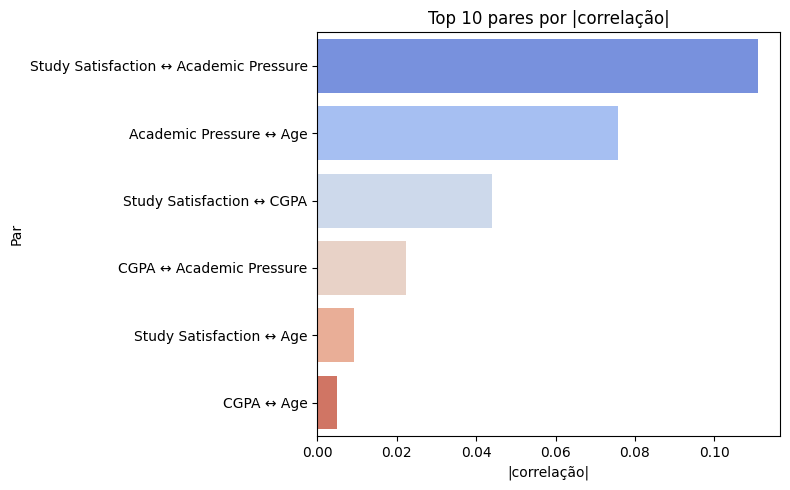

In [ ]:
corr = df_dataset[variaveis].corr(numeric_only=True).abs()

mask = np.triu(np.ones_like(corr, dtype=bool))
corr_tri = corr.where(~mask)

pairs = (
    corr_tri.stack()
    .reset_index()
    .rename(columns={'level_0':'Var 1', 'level_1':'Var 2', 0:'abs_corr'})
    .sort_values('abs_corr', ascending=False)
)

top_k = 10
top_pairs = pairs.head(top_k)
top_pairs['Par'] = top_pairs['Var 1'] + ' ↔ ' + top_pairs['Var 2']

print("Top pares por |correlação|:")
print(top_pairs[['Par', 'abs_corr']])

plt.figure(figsize=(8, 5))
sns.barplot(data=top_pairs, x='abs_corr', y='Par', orient='h', palette='coolwarm')
plt.title(f'Top {top_k} pares por |correlação|')
plt.xlabel('|correlação|')
plt.tight_layout()
plt.show()